**17. Visualizing the model**

In [1]:
# DL needs
import tensorflow as tf
import keras as kr

# Data needs
import pandas as pd
# Numerical computation needs
import numpy as np

# plotting needs
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# ensuring reproducibility
random_seed=42
tf.random.set_seed(random_seed)

# import the model 
from models.model import BIR_BLOCK,InceptionBlock,QUICKSAL_encoder,QUICKSAL_decoder,QUICKSAL,set_encoder_weights,mbnet


2025-05-02 07:22:48.528629: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


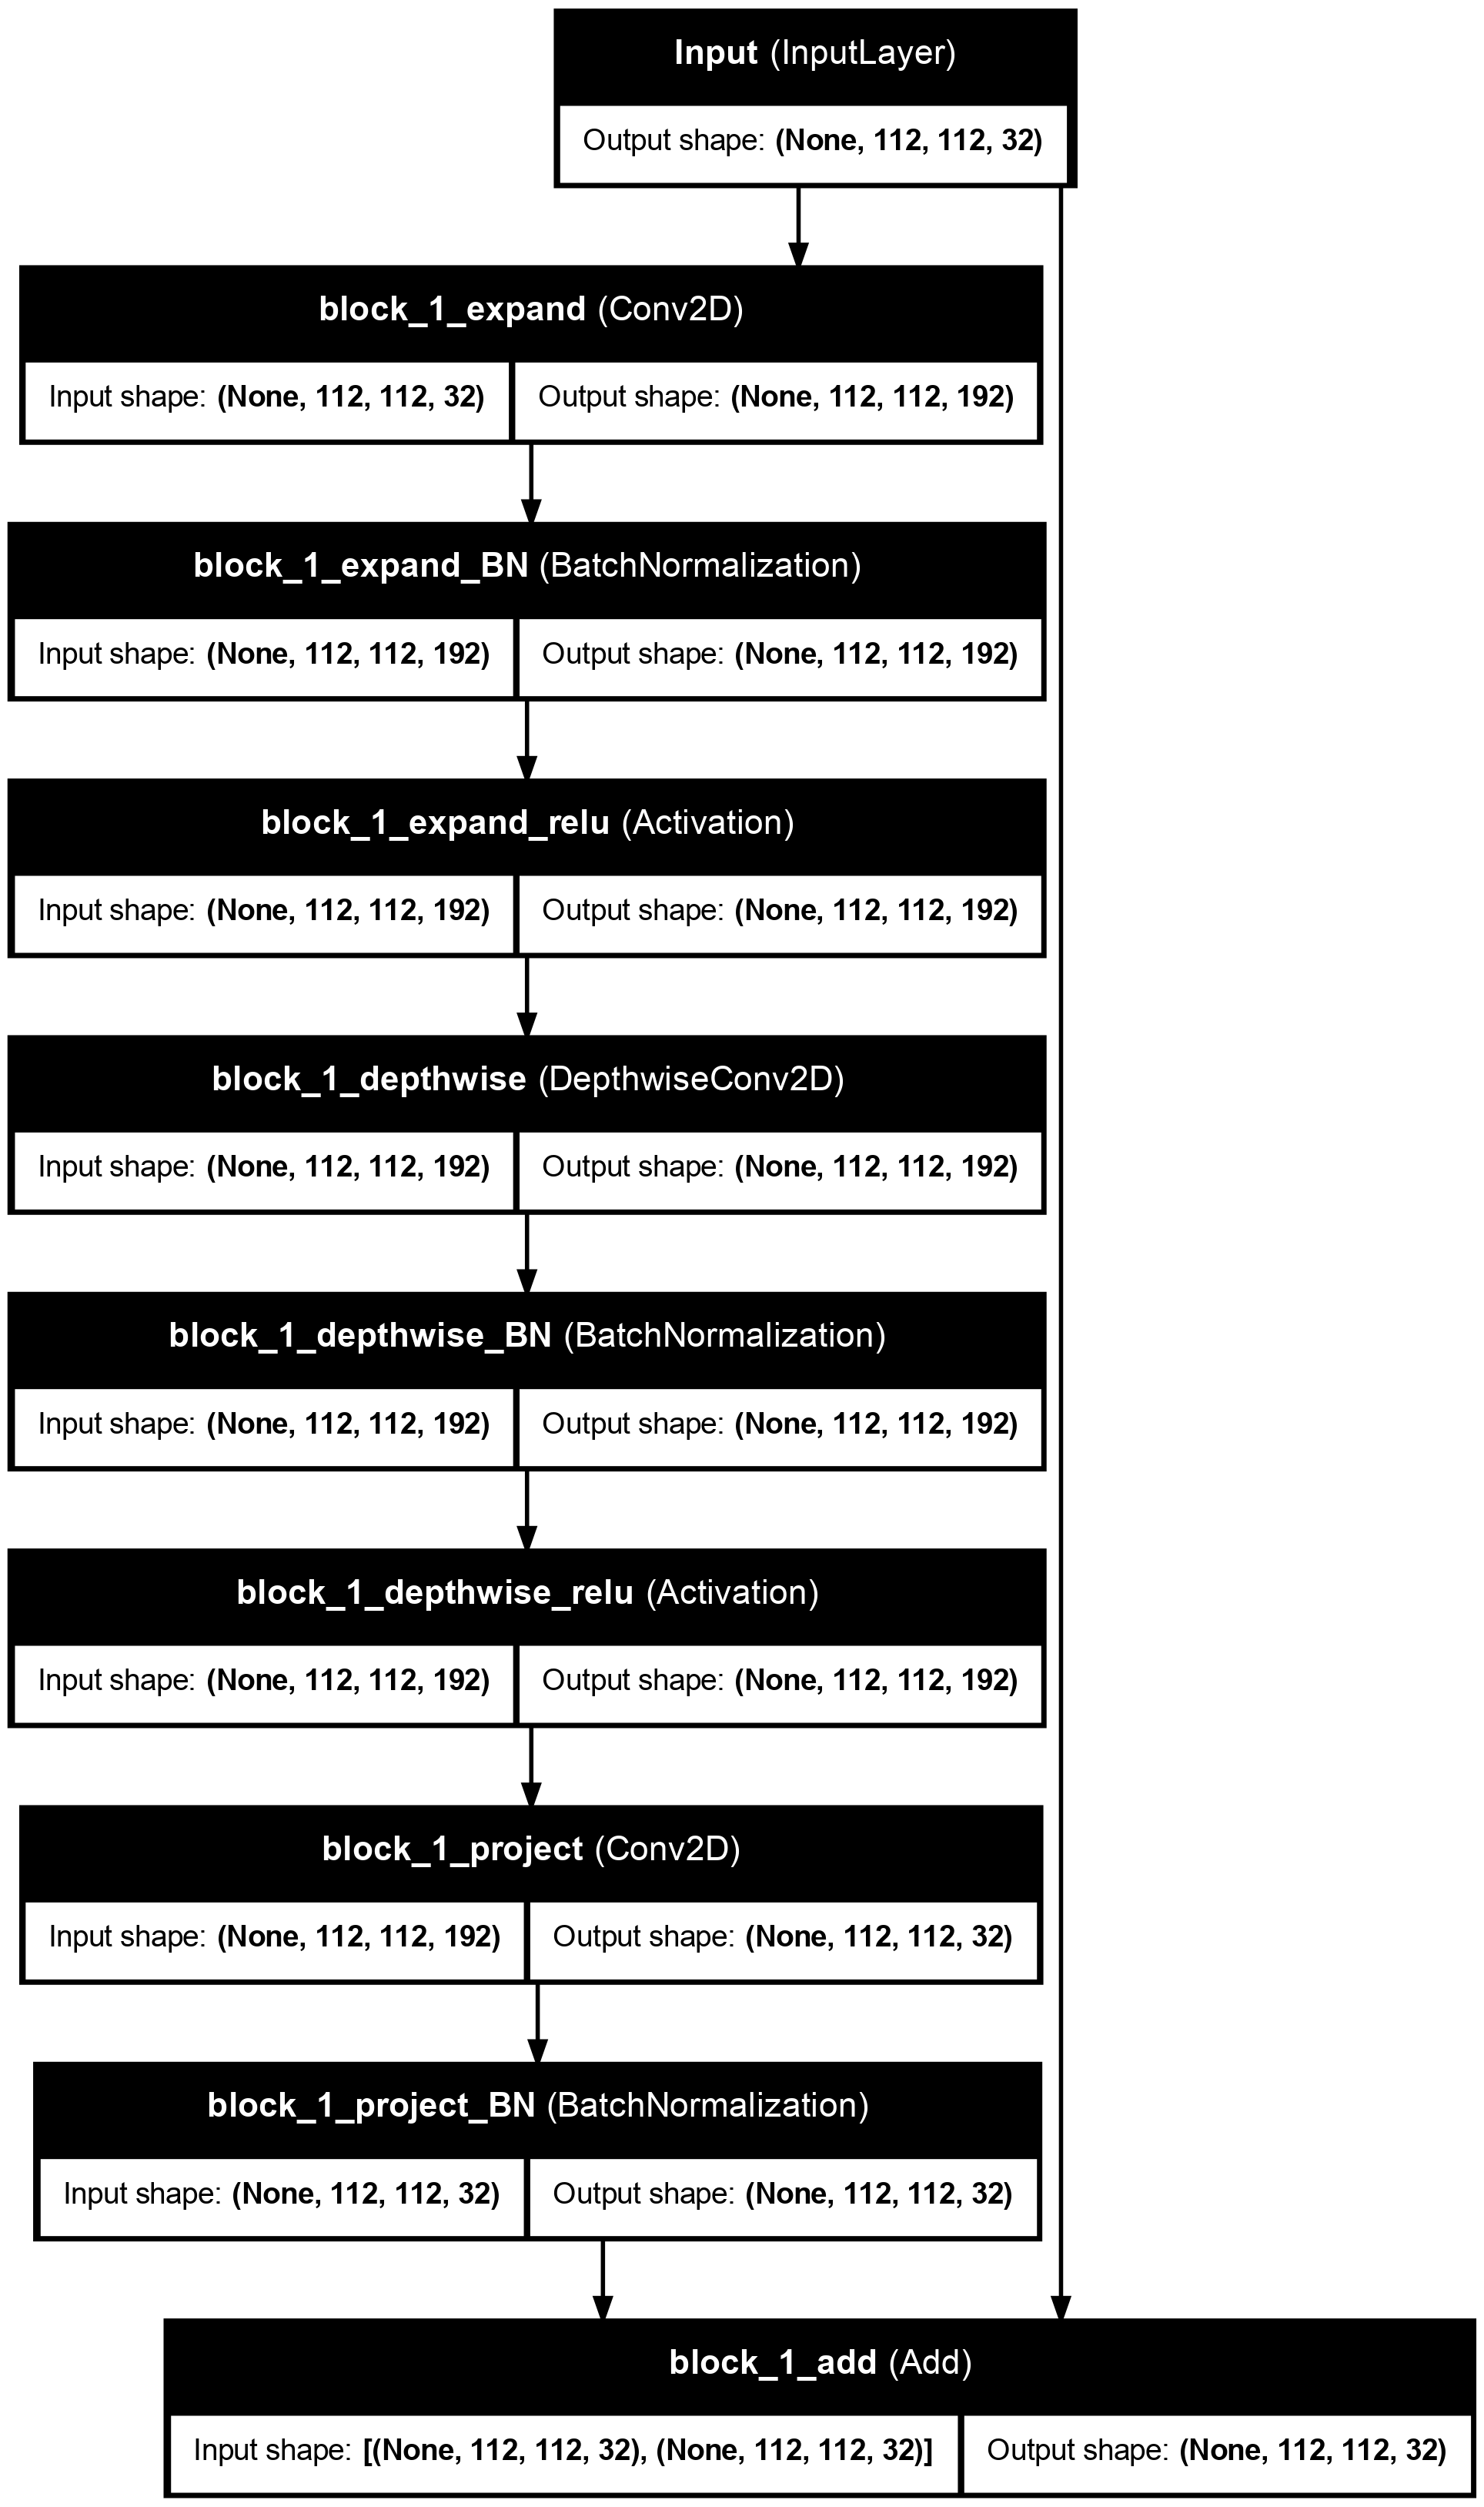

In [11]:
inputs = tf.keras.layers.Input((112,112,32),name = 'Input')
outputs = BIR_BLOCK(32,32,6,name = 'block_1').call(inputs)
bir_block = tf.keras.models.Model(inputs,outputs)
kr.utils.plot_model(bir_block,show_shapes=True, show_layer_names= True)


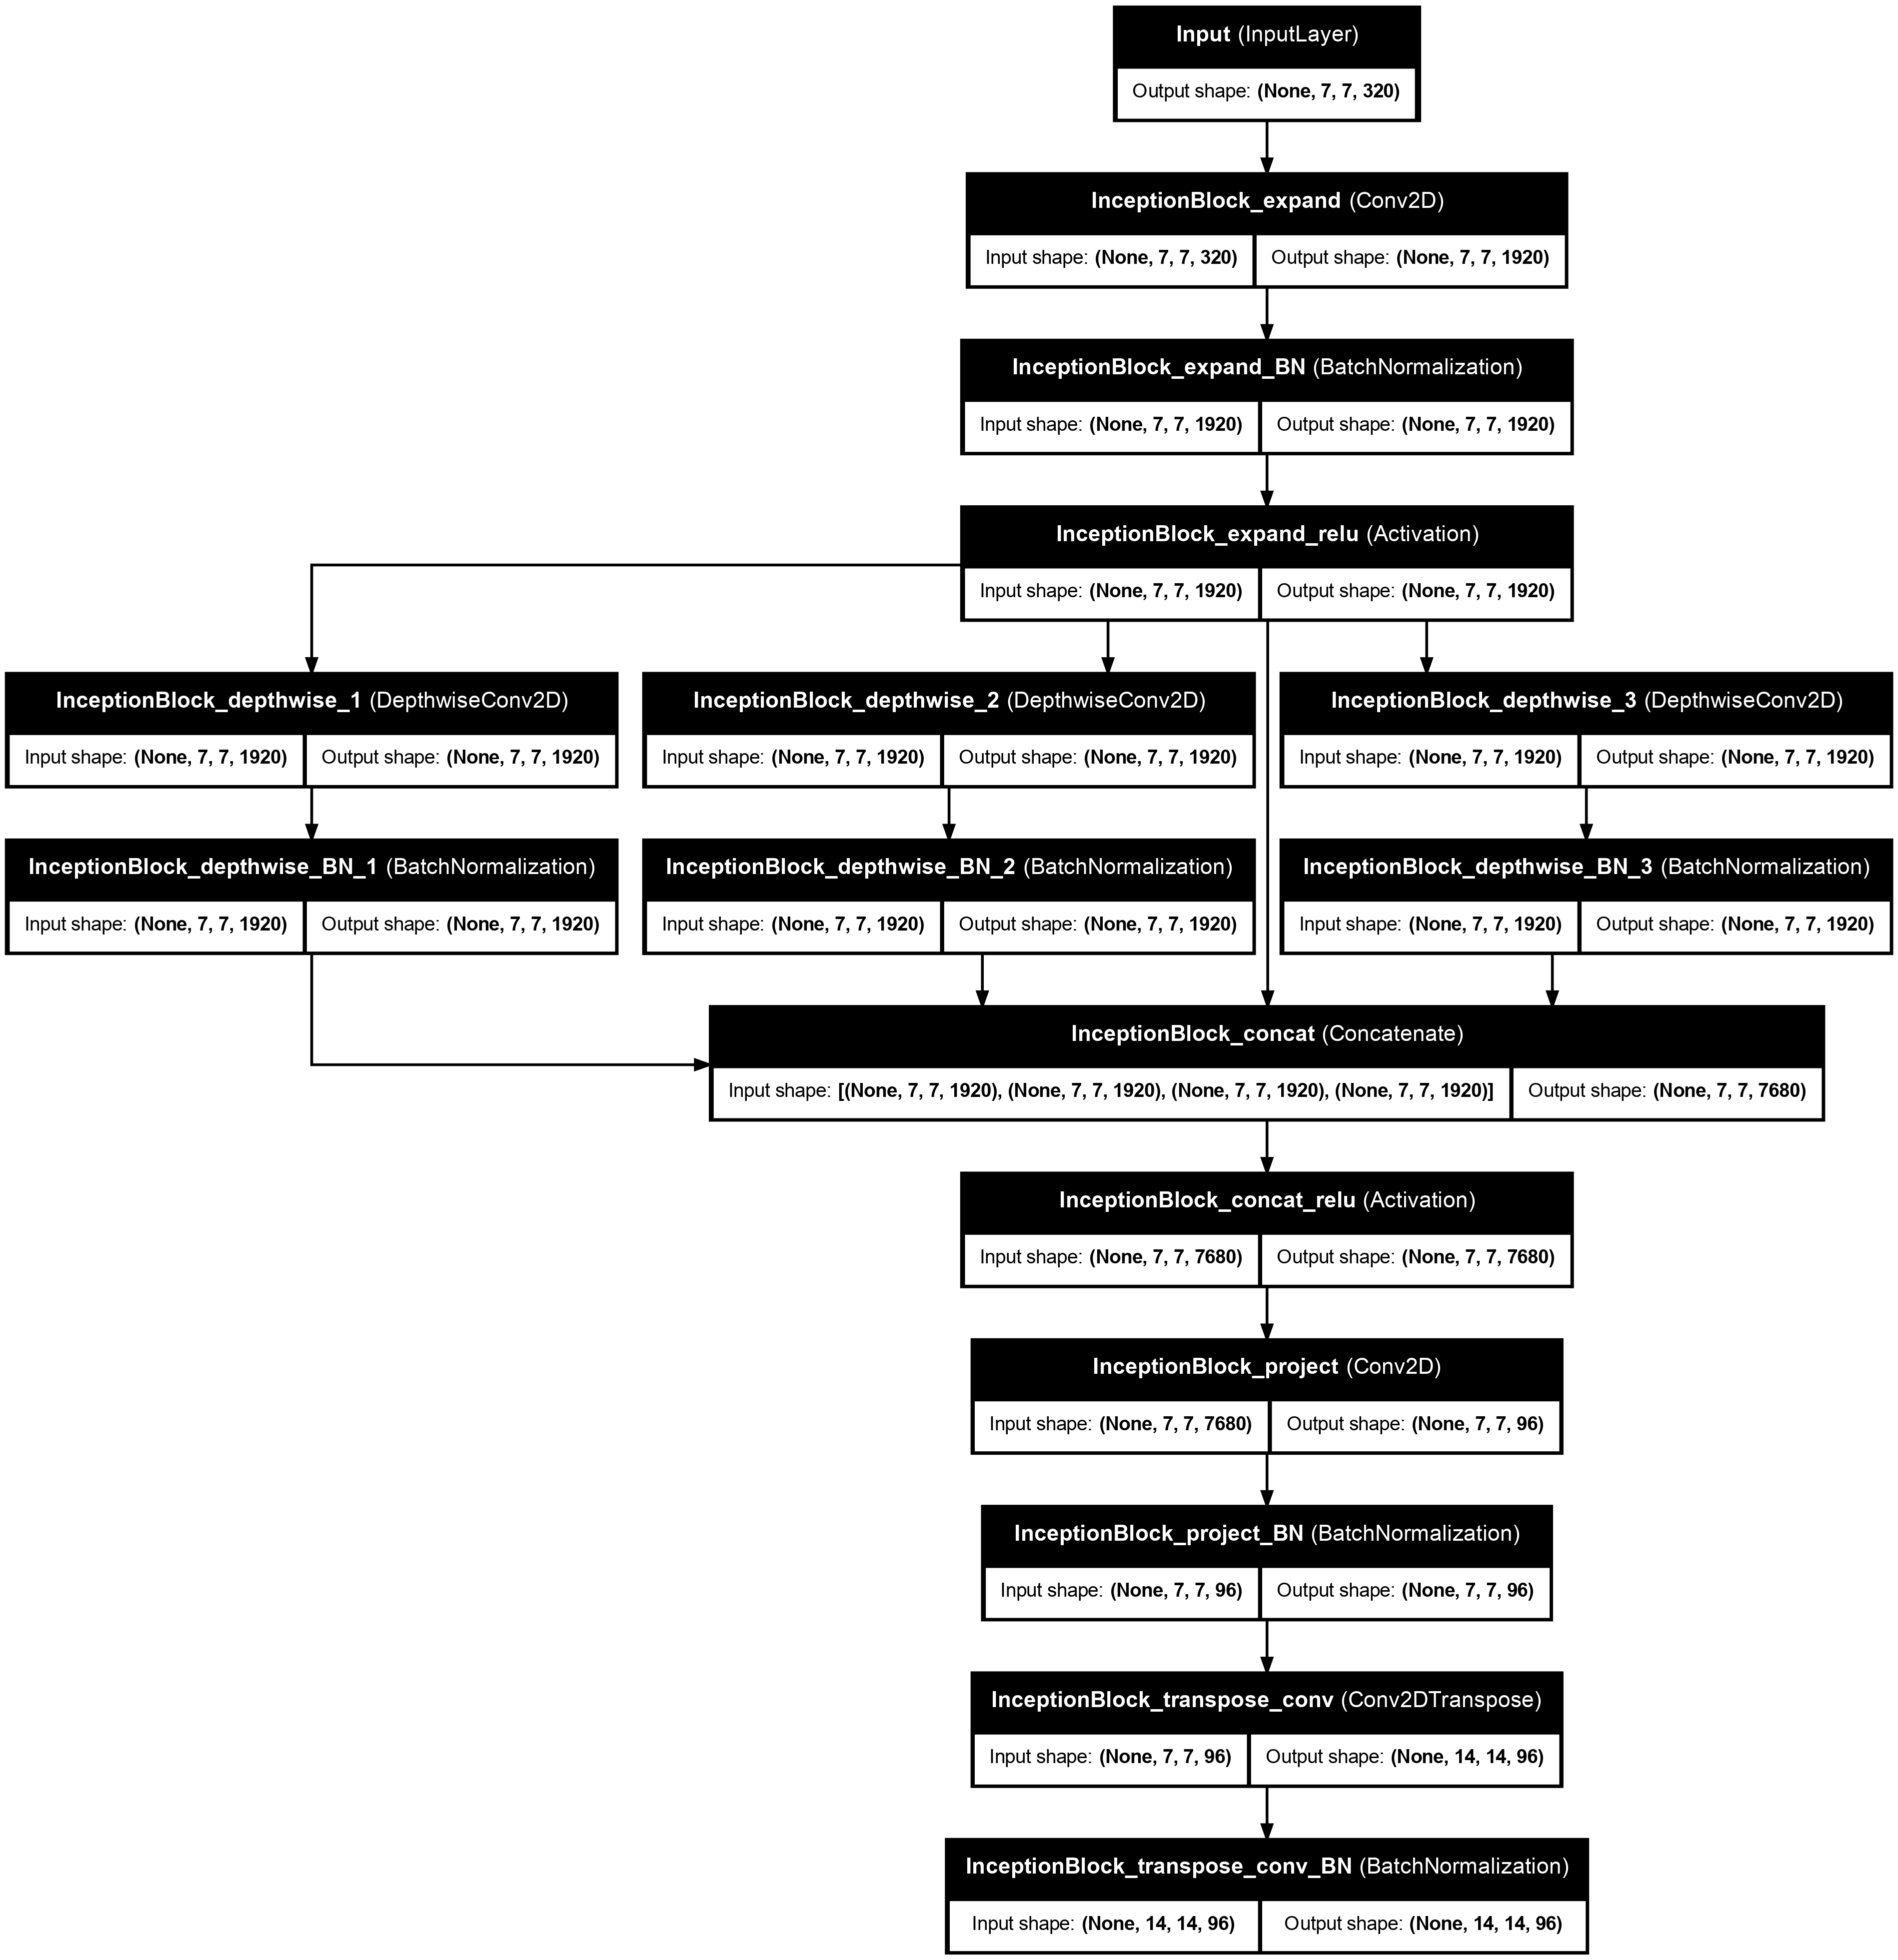

In [10]:
inputs = tf.keras.layers.Input((7,7,320),name = 'Input')
outputs = InceptionBlock(320,96,6).call(inputs)
inception_block = tf.keras.models.Model(inputs,outputs)
kr.utils.plot_model(inception_block,show_shapes=True, show_layer_names= True)

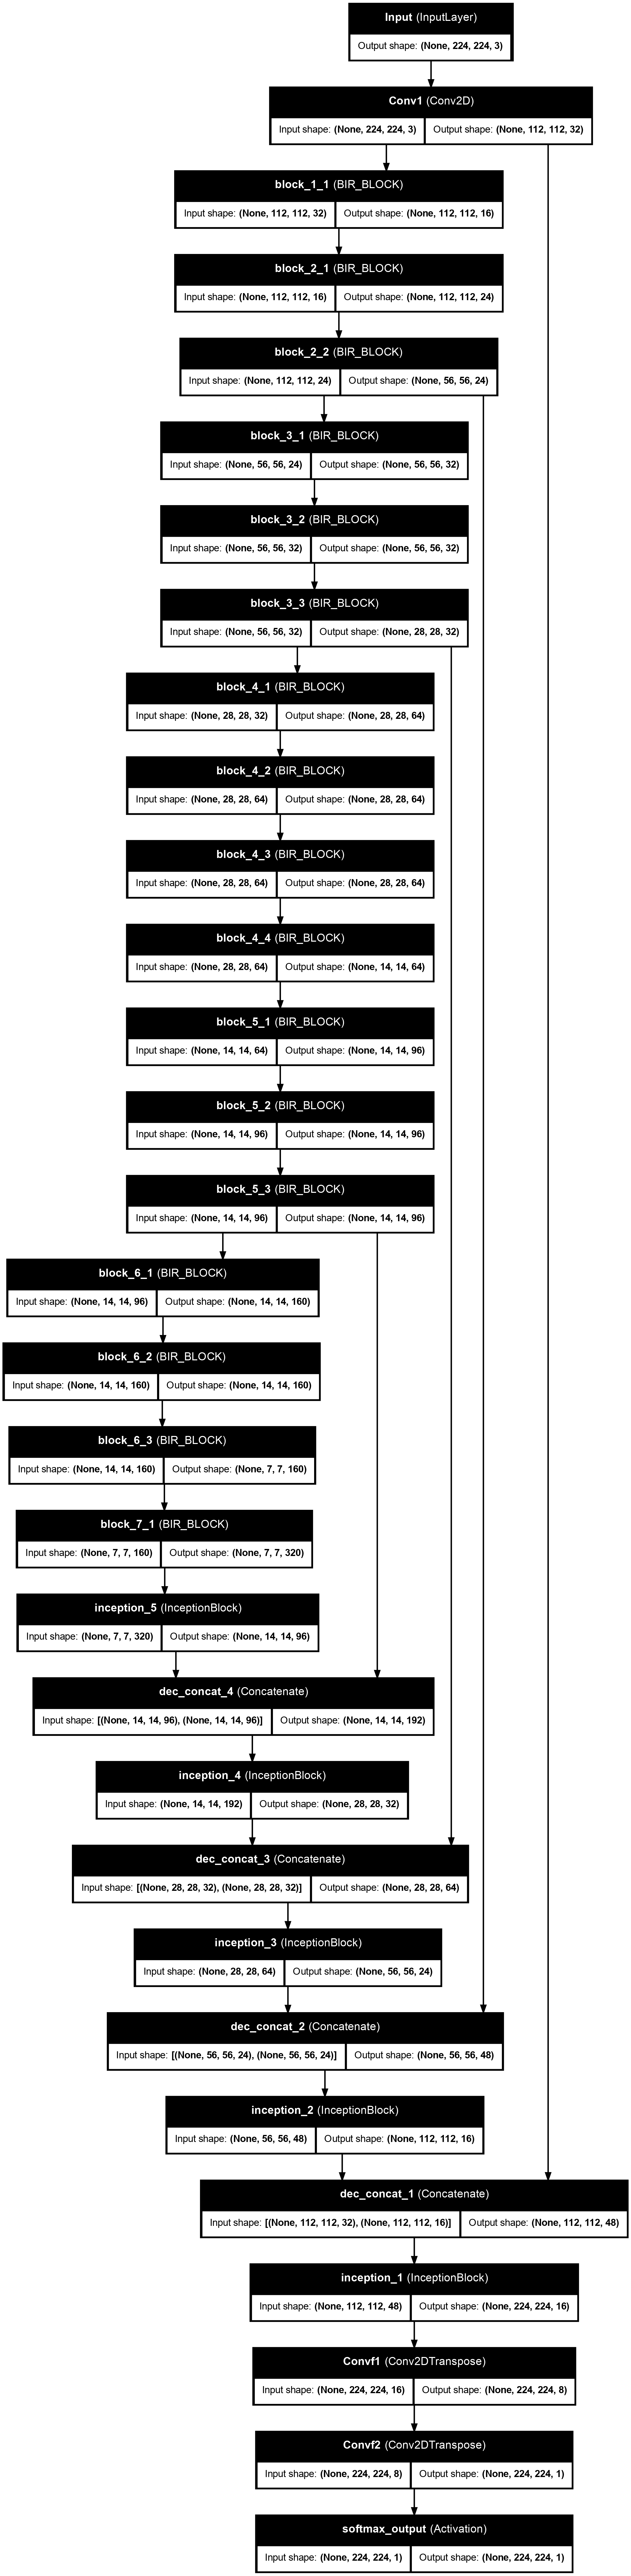

In [28]:
inputs = tf.keras.layers.Input((224,224,3),name = 'Input')
conv1_out = tf.keras.layers.Conv2D(filters = 32,
                            kernel_size = 3,
                            strides = 2,
                            padding = 'same',
                            use_bias = False,
                            name = 'Conv1')(inputs)

# encoder creation
encoder = QUICKSAL_encoder(name='QUICKSAL_encoder')
_=encoder(conv1_out) # building the encoder layer to be able to load pre-trained weights
set_encoder_weights(enc=encoder,mbnet=mbnet) # loading pre-trained weights

bir2_out,bir3_out,bir5_out,bir7_out = encoder.call(conv1_out)

# ensure that only the first layer of block 1 of encoder is trainable, rest all non-trainable
for layer in encoder._layers:
    layer.trainable = False

encoder._layers[0]._layers[0].trainable = True

# decoder creation
decoder = QUICKSAL_decoder(name = 'QUICKSAL_decoder')
decoder_out = decoder.call([conv1_out,bir2_out,bir3_out,bir5_out,bir7_out])

# transpose convolution layer to get the output
convf1_out = tf.keras.layers.Conv2DTranspose(filters = 8,
                                            kernel_size = 3,
                                            strides = 1,
                                            padding = 'same',
                                            use_bias = False, 
                                            # activation -> Linear
                                            name = 'Convf1')(decoder_out)

convf2_out = tf.keras.layers.Conv2DTranspose(filters = 1,
                                            kernel_size = 3,
                                            strides = 1,
                                            padding = 'same',
                                            use_bias = False,
                                            activation = 'softmax',
                                            name = 'Convf2')(convf1_out)

# for mixed precision training, we need softmax output to be tf.float32
outputs = tf.keras.layers.Activation('softmax',dtype = tf.float32, name = 'softmax_output')(convf2_out)

QUICKSAL = tf.keras.models.Model(inputs=inputs,outputs=outputs,name='QUICKSAL')

tf.keras.utils.plot_model(QUICKSAL,show_shapes=True,show_layer_names=True)


**Note:**
* This method appears to be a better approach